In [ ]:
import os
import glob
import tensorflow as tf
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
OUTPUT_PATH = "../data/splitted/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = "./model/model_keras.keras"

In [ ]:
viral_augment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

normal_augment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10
)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(OUTPUT_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(OUTPUT_PATH, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(OUTPUT_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4243 images belonging to 3 classes.
Found 908 images belonging to 3 classes.
Found 912 images belonging to 3 classes.


In [ ]:
def build_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', name="embedding")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
num_classes = train_generator.num_classes

model = build_model(input_shape, num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.5390 - loss: 4.9297 - val_accuracy: 0.7313 - val_loss: 0.7053
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 547s 4s/step - accuracy: 0.6749 - loss: 0.8227 - val_accuracy: 0.7654 - val_loss: 0.5882
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - accuracy: 0.7507 - loss: 0.6139 - val_accuracy: 0.7753 - val_loss: 0.5912
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 529s 4s/step - accuracy: 0.7425 - loss: 0.6193 - val_accuracy: 0.7786 - val_loss: 0.5857
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 523s 4s/step - accuracy: 0.7506 - loss: 0.6056 - val_accuracy: 0.7863 - val_loss: 0.5495
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 544s 4s/step - accuracy: 0.7686 - loss: 0.5720 - val_accuracy: 0.7665 - val_loss: 0.5631
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.7598 - loss: 0.5693 - val_accuracy: 0.7907 - val_loss: 0.5297
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.7839 - loss: 0.5509 - val_accu

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

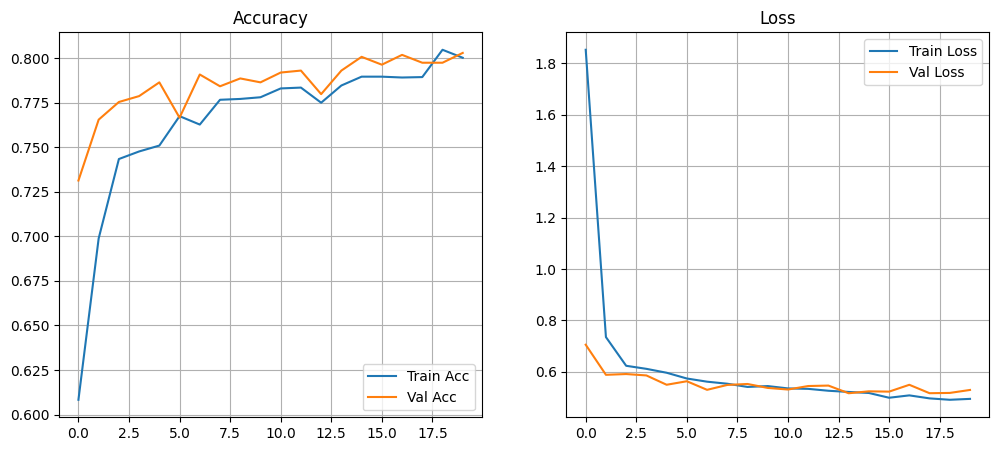

In [30]:
def plot_history(hist):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_history(history)


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 553ms/step - accuracy: 0.8536 - loss: 0.4043

Test Presicion: 0.8026
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 636ms/step

Classification Report:

              precision    recall  f1-score   support

   BACTERIAL       0.81      0.86      0.83       436
      NORMAL       0.85      0.97      0.90       238
       VIRAL       0.72      0.54      0.62       238

    accuracy                           0.80       912
   macro avg       0.79      0.79      0.78       912
weighted avg       0.80      0.80      0.79       912



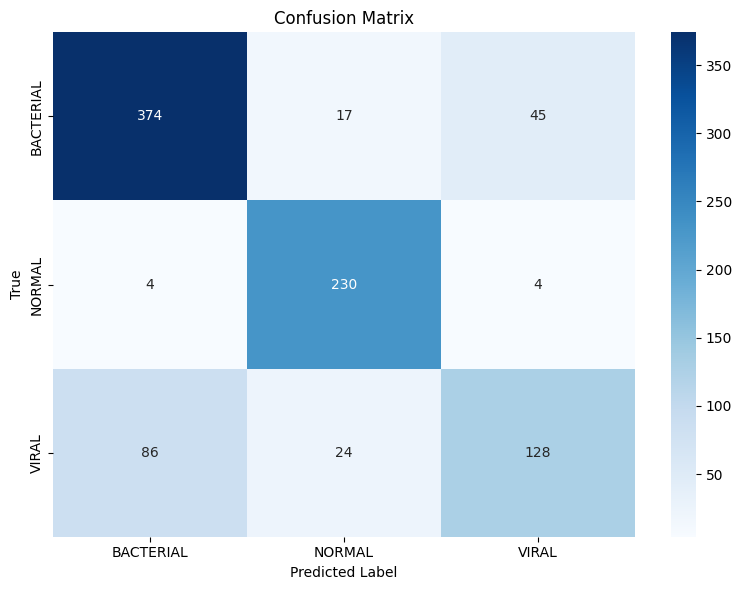

In [31]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Presicion: {test_acc:.4f}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True")
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
model.save("./model/model_keras.keras", save_traces=False)
print(f"\nBest model saved on: {MODEL_PATH}")

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
model = load_model(MODEL_PATH)

embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

embeddings = []
image_paths = []

for class_name in os.listdir(OUTPUT_PATH):
    class_dir = os.path.join(OUTPUT_PATH, class_name)
    if not os.path.isdir(class_dir):
        continue

    for img_path in glob.glob(os.path.join(class_dir, "**", "*.*"), recursive=True):
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            embedding = embedding_model.predict(img_array)
            embeddings.append(embedding[0])
            image_paths.append(img_path)

        except Exception as e:
            print(f"Error con {img_path}: {e}")

embeddings = np.array(embeddings)
image_paths = np.array(image_paths)

np.save("embedding/dataset_embeddings.npy", embeddings)
np.save("path/image_paths.npy", image_paths)

print("Paths and embeddings saved successfully.")



Embedding model created successfully.


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │   102,760,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,779,968 (392.07 MB)

 Trainable params: 102,779,968 (392.07 MB)

 Non-trainable params: 0 (0.00 B)

Model summary:
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━